# Bangla Travel Chatbot

This is a demo chatbot that answers questions related to travelling inside Bangladesh. The chatbot currently answers from a fix pool of questions or related questions. It will be made context aware in the future using word embeddings.


Collaborators: Shuvo Saha Roy, AK Niloy


Import necessary libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import io
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPool1D

Read dataset

In [2]:
dataset = pd.read_excel("QA_data.xlsx")
# dataset = dataset.sample(frac=1)
dataset.head()

,question,tags
0,What is the duration required for a bus journe...,time_duration_by_bus
1,Can you tell me how long it takes to travel fr...,time_duration_by_bus
2,How much time does a bus journey from Dhaka to...,time_duration_by_bus
3,What's the estimated travel time from Dhaka to...,time_duration_by_bus
4,Could you inform me about the duration of a bu...,time_duration_by_bus


In [3]:
import string
dataset['question'] = dataset['question'].apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])

In [4]:
dataset.head()

,question,tags
0,"[w, h, a, t, , i, s, , t, h, e, , d, u, r, ...",time_duration_by_bus
1,"[c, a, n, , y, o, u, , t, e, l, l, , m, e, ...",time_duration_by_bus
2,"[h, o, w, , m, u, c, h, , t, i, m, e, , d, ...",time_duration_by_bus
3,"[w, h, a, t, s, , t, h, e, , e, s, t, i, m, ...",time_duration_by_bus
4,"[c, o, u, l, d, , y, o, u, , i, n, f, o, r, ...",time_duration_by_bus


In [5]:
dataset['question'] = dataset['question'].apply(lambda wrd: ''.join(wrd))
dataset.head()

,question,tags
0,what is the duration required for a bus journe...,time_duration_by_bus
1,can you tell me how long it takes to travel fr...,time_duration_by_bus
2,how much time does a bus journey from dhaka to...,time_duration_by_bus
3,whats the estimated travel time from dhaka to ...,time_duration_by_bus
4,could you inform me about the duration of a bu...,time_duration_by_bus


Convert the input and the output into tokens. Here the output is the tags that 
the chatbot needs to search for a particular question. Each word is represented with a numeric value

In [26]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset['question'])
train = tokenizer.texts_to_sequences(dataset['question'])
features = pad_sequences(train)
le = LabelEncoder()
labels = le.fit_transform(dataset['tags'])
tag_sample = le.inverse_transform(labels)[0]
print(f'tag_sample: {tag_sample}')
print(f'Length of a input feature : {len(features[0])}')
print(f'Shape of input feature : {features.shape}')
print(f'Example of an input feature : {features[0]}')

tag_sample: time_duration_by_bus
Length of a input feature : 23
Shape of input feature : (872, 23)
Example of an input feature : [  0   0   0   0   0   0   0   0   0   7  11   1 115 133   5  18  31  37
  14  13   9   2   3]


Check the number of unique words in the dataset.

In [75]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)
print(tokenizer.word_index)

number of unique words :  674
output length:  12
{'the': 1, 'coxs': 2, 'bazar': 3, 'in': 4, 'for': 5, 'are': 6, 'what': 7, 'which': 8, 'to': 9, 'and': 10, 'is': 11, 'of': 12, 'dhaka': 13, 'from': 14, 'traditional': 15, 'that': 16, 'this': 17, 'a': 18, 'town': 19, 'most': 20, 'suitable': 21, 'resorts': 22, 'their': 23, 'time': 24, 'or': 25, 'recommended': 26, 'tourists': 27, 'comfortable': 28, 'travel': 29, 'can': 30, 'bus': 31, 'offer': 32, 'food': 33, 'coxbazar': 34, 'dress': 35, 'season': 36, 'journey': 37, 'options': 38, 'suitability': 39, 'how': 40, 'tourist': 41, 'i': 42, 'known': 43, 'you': 44, 'attire': 45, 'best': 46, 'stay': 47, 'clothing': 48, 'shops': 49, 'experience': 50, 'preferred': 51, 'traveling': 52, 'by': 53, 'provide': 54, 'spots': 55, 'resort': 56, 'specific': 57, 'transportation': 58, 'have': 59, 'where': 60, 'popular': 61, 'costeffective': 62, 'be': 63, 'culinary': 64, 'mode': 65, 'highly': 66, 'hotels': 67, 'restaurants': 68, 'there': 69, 'cultural': 70, 'indigen

Train test split the dataset

In [59]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
print(f'train_features : {train_features.shape}, test_features: {test_features.shape}')

train_features : (697, 23), test_features: (175, 23)


### Complex LSTM Model

In [60]:
# m = Sequential()
# m.add(Input(shape=(features.shape[1])))
# m.add(Embedding(vocabulary + 1,100))
# m.add(Conv1D(filters=32, kernel_size=5, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001), kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
# m.add(Dropout(0.3))
# m.add(LSTM(32, dropout=0.3,return_sequences=True))
# m.add(LSTM(16, dropout=0.3,return_sequences=False))
# m.add(Dense(128,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
# m.add(Dropout(0.6))
# m.add(Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))

### simple LSTM model

In [61]:
# m = Sequential()
# m.add(Embedding(vocabulary + 1, 100, input_length=input_shape))
# m.add(LSTM(64))
# m.add(Dense(output_length, activation="softmax"))

### Bidirectional LSTM

In [62]:
# from tensorflow.keras.layers import Bidirectional

# m = Sequential()
# m.add(Embedding(vocabulary + 1, 100, input_length=input_shape))
# m.add(Bidirectional(LSTM(64)))
# m.add(Dense(output_length, activation="softmax"))

### GRU

In [82]:
from tensorflow.keras.layers import GRU

def model(vocabulary):
    x = Sequential()
    x.add(Embedding(vocabulary + 1, 100, input_length=input_shape))
    x.add(GRU(64))
    x.add(Dense(output_length, activation="softmax"))
    return x



In [83]:
model = model(vocabulary)

Download the glove.6B.100d.txt file and put it in the root folder.

!curl -O https://nlp.stanford.edu/data/glove.6B.zip

Global Vectors for Word Representation. This is a word corpus that is used for context later on.

In [84]:
glove_dir = "glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir, encoding='utf-8')
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [85]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(f'Embedded Matrix : {embedding_matrix.shape}')
print(f'Embedded Matrix sample : {embedding_matrix[45]}')

Embedded Matrix : (675, 100)
Embedded Matrix sample : [0.36774998903274536 -0.1048400029540062 0.05081599950790405
 -0.1679999977350235 -0.763949990272522 0.9455500245094299
 0.0660799965262413 0.5367100238800049 -0.7136899828910828
 0.9945899844169617 -0.6243799924850464 -0.43386998772621155
 1.1196000576019287 0.20298999547958374 0.4173699915409088
 -0.020253999158740044 0.26385000348091125 0.013458999805152416
 0.4102500081062317 -0.5462700128555298 -0.16118000447750092
 -0.7106800079345703 0.1806199997663498 -0.44475001096725464
 -0.10215000063180923 0.3942599892616272 -0.36469998955726624
 -0.7273499965667725 -0.40536999702453613 -0.8830199837684631
 0.05053599923849106 -0.22916999459266663 -0.35819000005722046
 -0.6256099939346313 0.81045001745224 0.6374499797821045
 -0.2487500011920929 -0.07460799813270569 -0.5765399932861328
 -0.06300999969244003 0.19922000169754028 0.1475600004196167
 0.33441999554634094 0.31435999274253845 -0.8565000295639038
 -0.8796200156211853 0.1370799988

# Training

In [86]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True


In [87]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 23, 100)           67500     
                                                                 
 gru_5 (GRU)                 (None, 64)                31872     
                                                                 
 dense_5 (Dense)             (None, 12)                780       
                                                                 
Total params: 100,152
Trainable params: 100,152
Non-trainable params: 0
_________________________________________________________________


In [88]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'accuracy', patience = 10)

In [90]:
# history_training = m.fit(features,labels,epochs=100, batch_size=64, callbacks=[ earlyStopping])

history_training = model.fit(train_features, train_labels, epochs=100, batch_size=64, callbacks=[earlyStopping])

Epoch 1/100
11/11 [==============================] - 3s 19ms/step - loss: 2.3735 - accuracy: 0.2339
Epoch 2/100
11/11 [==============================] - 0s 17ms/step - loss: 1.8910 - accuracy: 0.3917
Epoch 3/100
11/11 [==============================] - 0s 17ms/step - loss: 1.5778 - accuracy: 0.5495
Epoch 4/100
11/11 [==============================] - 0s 16ms/step - loss: 1.2962 - accuracy: 0.6829
Epoch 5/100
11/11 [==============================] - 0s 16ms/step - loss: 1.0091 - accuracy: 0.7920
Epoch 6/100
11/11 [==============================] - 0s 20ms/step - loss: 0.7484 - accuracy: 0.8680
Epoch 7/100
11/11 [==============================] - 0s 17ms/step - loss: 0.5238 - accuracy: 0.9067
Epoch 8/100
11/11 [==============================] - 0s 17ms/step - loss: 0.3675 - accuracy: 0.9283
Epoch 9/100
11/11 [==============================] - 0s 16ms/step - loss: 0.2621 - accuracy: 0.9412
Epoch 10/100
11/11 [==============================] - 0s 18ms/step - loss: 0.1840 - accuracy: 0.9770

In [91]:
history_training.history['accuracy'][-1],history_training.history['loss'][-1]

(1.0, 0.011721491813659668)

# Testing

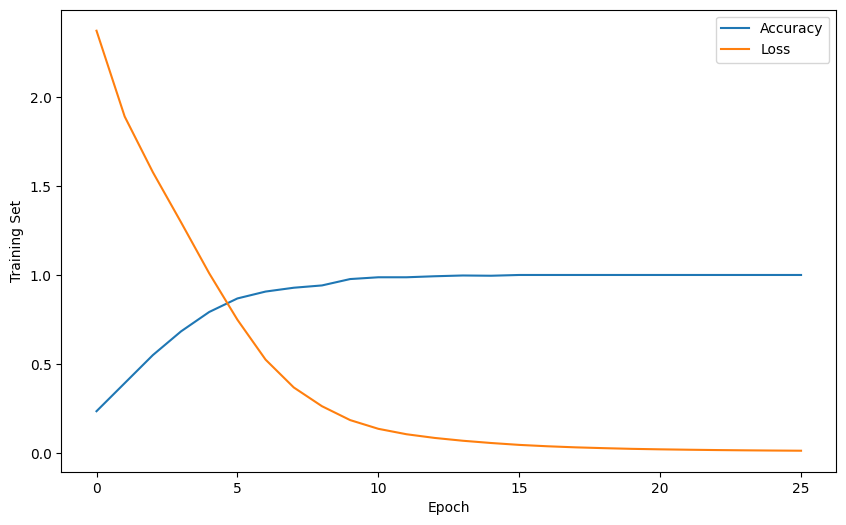

In [92]:
def draw_plot(data_dict, type_data):
#     mpl.style.use('seaborn')
    plt.figure(figsize=(10, 6))
    for label, data in data_dict.items():
        plt.plot(data, label=label)
    plt.xlabel('Epoch')
    plt.ylabel(type_data)
    plt.legend()
    plt.show()

data_dict = {
    'Accuracy': history_training.history['accuracy'],
    'Loss': history_training.history['loss']
}

draw_plot(data_dict, 'Training Set')


In [96]:
loss, accuracy = model.evaluate(test_features, test_labels, batch_size=64)

3/3 [==============================] - 1s 7ms/step - loss: 0.0195 - accuracy: 1.0000


6/6 [==============================] - 0s 4ms/step


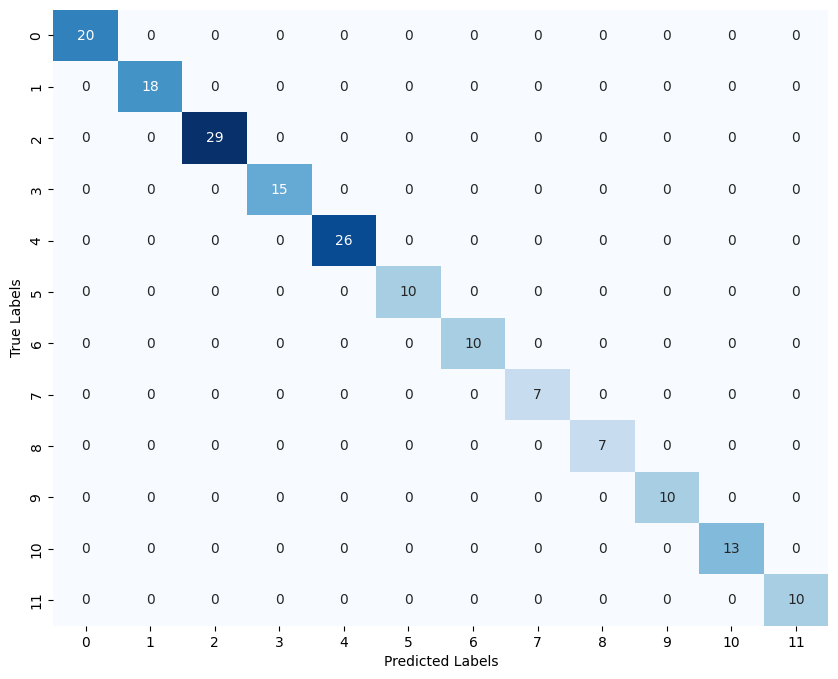

In [102]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model.predict(test_features)
predicted_labels = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


For the initial step, some predefined responses will be generated from the list of answers below. This will be updated soon.

In [98]:
responses = {
  
    "time_duration_by_bus": ["9-11 hours", "7- 8 hours", "11-12 hours", "7- 8 hours", "5 - 6 hours"],
    "time_duration_by_air": ["30-40 minute", "50-60 minute", "40-50 minute", "60-70 minute"],
    "suitable_time_for_coxs_bazar": ["Night", "Day"],
    "suitable_climate_or_season_for_coxs_bazar": ["winter", "rainy", "summer"],
    "comfotable_and_safe_transport_for_dahaka to coxsbazar": ["Air", "Bus", "train"],
    "popular_spot": ["Cox's Bazar Beach", "Marin Drive", "Inani Beach", "Laboni Beach", "Hima Chori"],
    "popular_hotel": ["Hotel The Cox Today", "Praasad Paradise", "Seagull Hotels", "Praasad Paradise", "Sea Pearl Beach Resort & Spa Cox's Bazar", "Muscat Holiday Resort"],
    "popular_restaurants": ["Mermaid Cafe", "Coral station", "Poushee Restaurant", "Chui Jhal"],
    "traditional_food": ["Shutki bhorta", "Big Rupchada", "fish fry", "Loitta fry", "Muri Ghonto", "Shutki bhorta"],
    "type_of_indigenous_people": ["chakma", "Tanchangya", "marma", "Tanchangya",
      "Bawm "
    ],
    "traditional_clothes": ["Pha-khum", "punjabi", "lingpi", "thewa", "mekhla"],
    "cost_effective_shop": ["Burmese Market(near cox's bazar)", "The Cox City Super Market", "K&K Burmese Market", "Bangla Bazar Station"]

 }

In [100]:
import random
def generate_answer(query):
  texts = []
  pred_input = query
#   pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],input_shape)
  output = model.predict(pred_input)
  output = output.argmax()
  response_tag = le.inverse_transform([output])[0]
  return random.choice(responses[response_tag])

In [101]:
list_que = ["What are some recommended shops known for their cost-effective options for suitable traditional dress?", 
            "Where can I find traditional attire that is both suitable and affordable?",
            "How much time does the journey from Dhaka to Cox's Bazar take??"]
for i in list_que:
  print("you: {}".format(i))
  res_tag = generate_answer(i)
  print(res_tag)  

you: What are some recommended shops known for their cost-effective options for suitable traditional dress?
1/1 [==============================] - 0s 26ms/step
K&K Burmese Market
you: Where can I find traditional attire that is both suitable and affordable?
1/1 [==============================] - 0s 23ms/step
Burmese Market(near cox's bazar)
you: How much time does the journey from Dhaka to Cox's Bazar take??
1/1 [==============================] - 0s 31ms/step
5 - 6 hours


In [37]:
query = "season for travel to coxbazar?"
res_tag = generate_answer(query)
print(res_tag)  

1/1 [==============================] - 0s 25ms/step
summer
